In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import hyperspy.api as hs

import diffpy
from diffpy.structure import Atom, Structure, Lattice, loadStructure

from orix import plot, sampling
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d, Miller
from orix.io import load, save
from orix.projections import StereographicProjection

from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from diffsims.generators.zap_map_generator import get_rotation_from_z_to_direction

import pyxem as pxm
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls
from pyxem.utils.plotting_utils import plot_template_over_pattern


# File

In [2]:
file = 'SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed_DoG.hdf5'

## Make a custom dataset with each phase separated

0.01904
Using previously made custom dataset


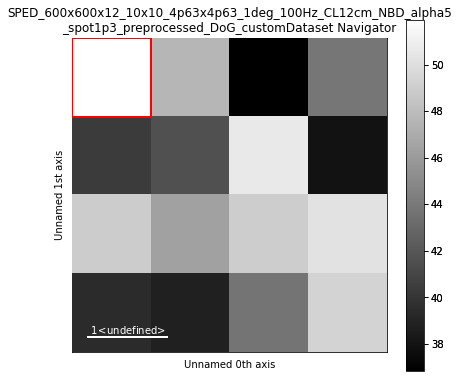

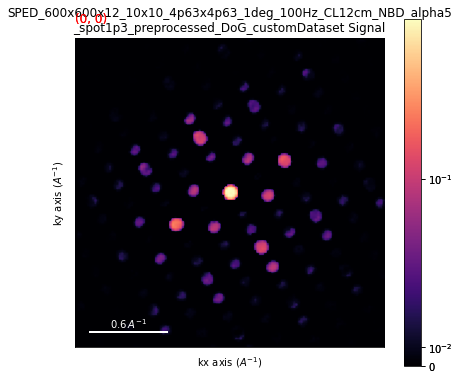

In [3]:
try:
    experimental_data = hs.load('SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed_DoG_customDataset.hdf5')
    experimental_data.set_signal_type('electron_diffraction')
    diffraction_calibration = experimental_data.axes_manager[2].scale
    print(diffraction_calibration)
    print("Using previously made custom dataset")
except:
    experimental_data = hs.load(file, lazy=True)
    experimental_data.set_signal_type('electron_diffraction')
    diffraction_calibration = experimental_data.axes_manager[2].scale
    print(diffraction_calibration)

    # Theta Primes, needles [100]/[010]
    A_11 = experimental_data.inav[112,422].data # Nice pattern 128,395 is other option
    A_12 = experimental_data.inav[ 74,405].data # More noise and other in plane rot, 101,75: less reflections
    A_13 = experimental_data.inav[343,175].data # Overlapping and changing intensities, T1 weaker...
    A_14 = experimental_data.inav[416,433].data # Weak overlapping signals, ish same intensities.
    # Theta Primes, in plane [001]
    A_21 = experimental_data.inav[251,455].data # Fairly decent signal
    A_22 = experimental_data.inav[355, 77].data # Weaker reflections
    A_23 = experimental_data.inav[ 43, 84].data # Overlapping in plane theta and T1, weak signal-to-noice
    A_24 = experimental_data.inav[ 92, 56].data # Overlapping in plane theta and needle, weak signals...
    # T1, [041]
    A_31 = experimental_data.inav[194,248].data # T1 horizontal, weak, but all are...
    A_32 = experimental_data.inav[450,253].data # T1 vertical, stronger
    A_33 = experimental_data.inav[434, 22].data # T1 both orientations overlap
    A_34 = experimental_data.inav[205,431].data # T1 overlap theta prime, weak sign both
    # Al, [001]
    A_41 = experimental_data.inav[216,138].data # Just Al, little noise
    A_42 = experimental_data.inav[360, 29].data # noisier Al
    A_43 = experimental_data.inav[ 48, 29].data # Al very close to in plane theta
    A_44 = experimental_data.inav[104,451].data # Al different background for some reason...

    A = np.array([[A_11, A_12, A_13, A_14],
                [A_21, A_22, A_23, A_24],
                [A_31, A_32, A_33, A_34],
                [A_41, A_42, A_43, A_44]])

    custom_dataset = hs.signals.Signal2D(A)
    custom_dataset.set_signal_type('electron_diffraction')
    custom_dataset.set_diffraction_calibration(diffraction_calibration)
    experimental_data = custom_dataset

experimental_data.plot(cmap='magma', norm='symlog')

In [4]:
#experimental_data.save('SPED_600x600x12_10x10_4p63x4p63_1deg_100Hz_CL12cm_NBD_alpha5_spot1p3_preprocessed_DoG_customDataset.hdf5')

# Choose your DP and what phase you expect to find

In [5]:
# give the coordintes for the DP to look at
dp_x = 0 # DP
dp_y = 0 # phase
experimental_data = experimental_data.inav[dp_x,dp_y]

#Possible choices:['ThetaPrime100', 'ThetaPrime001', 'T1', 'Al']
phases = np.array(['ThetaPrime100', 'ThetaPrime001', 'T1', 'Al'])
use_phase = phases[dp_y]

#experimental_data = experimental_data.inav[6, 44] 
print('Using dp at (x,y): (', dp_x, dp_y, ') and phase:', use_phase)

print(dp_y, phases[dp_y])

Using dp at (x,y): ( 0 0 ) and phase: ThetaPrime100
0 ThetaPrime100


# 1) Now get rotation lists and limit tilt ranges

In [6]:
# Set a rotation resolution and get rotations lists for the relevant crystal structures:
resolution = 0.5 # maximum angle in degrees between nearest templates.
threshold = 3  # Degrees, how far off a zone axis simulated

In [7]:
# Getting the rotation lists:
cubic_grid = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge") #Al
Al_structure = diffpy.structure.loadStructure(r'Al.cif')

hex_grid = get_beam_directions_grid("hexagonal", resolution, mesh="spherified_cube_edge") #T1
T1_structure      = diffpy.structure.loadStructure(r'T1.cif')

tetra_grid = get_beam_directions_grid("tetragonal", resolution, mesh="spherified_cube_edge") #theta
ThetaPrime_structure      = diffpy.structure.loadStructure(r'thetaprime.cif')

c:\Users\torit\Anaconda3\envs\hyperspy_latest\lib\site-packages\diffsims\generators\sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


## A tilt limiting function

In [8]:
def _new_structure_matrix_from_alignment(old_matrix, x=None, y=None, z=None):
    """Taken from orix v0.9, see
    https://github.com/pyxem/orix/blob/fb269b0456163aa3ac1f80498a9894c53953dccb/orix/crystal_map/phase_list.py#L794-L845.
    
    Explanation of why changing the structure matrix (base) to use orix with
    ReciPro, which uses another alignment, is needed:
    https://orix.readthedocs.io/en/stable/crystal_reference_frame.html.
    """
    if sum([i is None for i in [x, y, z]]) > 1:
        raise ValueError("At least two of x, y, z must be set.")

    # Old direct lattice base (row) vectors in Cartesian coordinates
    old_matrix = Vector3d(old_matrix)
    ad, bd, cd = old_matrix.unit

    # Old reciprocal lattice base vectors in cartesian coordinates
    ar = bd.cross(cd).unit
    br = cd.cross(ad).unit
    cr = ad.cross(bd).unit

    # New unit crystal base
    new_vectors = Vector3d.zero((3,))
    axes_mapping = {"a": ad, "b": bd, "c": cd, "a*": ar, "b*": br, "c*": cr}
    for i, al in enumerate([x, y, z]):
        if al in axes_mapping.keys():
            new_vectors[i] = axes_mapping[al]
    other_idx = {0: (1, 2), 1: (2, 0), 2: (0, 1)}
    for i in range(3):
        if np.isclose(new_vectors[i].norm, 0):
            other0, other1 = other_idx[i]
            new_vectors[i] = new_vectors[other0].cross(new_vectors[other1])

    # New crystal base
    new_matrix = new_vectors.dot(old_matrix.reshape(3, 1)).round(12)

    return new_matrix

#Defining a function that returns the tilt range of interest around a given zone axis for a given structure:
def get_tilt_range_around_zone(phase_object, zone_axis, euler_grid, max_tilt):
    '''
    phase_object : Orix phase object (Ex. Phase(name='T1', space_group=191, structure=T1_structure))
    zone_axis : The zone axis you want to rotate about
    euler_grid : the total rotation grid needed to describe whole crystal
    max_tilt : The maximum angle deviation from zone axis to be included
    '''
    # Input
    uvw = zone_axis
    phase = phase_object.deepcopy()
    
    # Change structure matrix (crystal lattice base)
    # NB! Use with care, since orix assumes another alignment, e1||a, e3||c*!
    lat = phase.structure.lattice
    new_base = _new_structure_matrix_from_alignment(lat.base, x="a*", z="c")
    lat.setLatBase(new_base)
        
    # Sample grid
    g_grid = Rotation.from_euler(np.deg2rad(euler_grid))

    # Rotate Zs (optic axis) into *cartesian* crystal coordinates
    rz = Vector3d.zvector()
    hz = g_grid * rz

    # Cartesian crystal coordinates in Miller indices <uvw> (unit cell coordinates)
    hz_miller = Miller(xyz=hz.data, phase=phase)
    hz_miller.coordinate_format = "uvw"

    # Rotate into fundamental sector defined in orix
    hz_miller = hz_miller.in_fundamental_sector()

    # Define zone axis and symmetrically equivalent directions
    za = Miller(uvw=uvw, phase=phase)
    za2 = za.symmetrise(unique=True)

    # Get disorientation angle (smallest misorientation angle under symmetry)
    hz_miller2 = hz_miller.reshape(hz_miller.size, 1)
    za2 = za2.reshape(1, za2.size)
    all_angles = za2.angle_with(hz_miller2)
    angles = all_angles.min(axis=1)

    # Get orientations within threshold
    mask = angles <= np.deg2rad(threshold)
    masked_euler_grid = euler_grid[mask]
    
    if False:
        fig = plt.figure()
        ax = fig.add_subplot(projection="ipf", symmetry=phase.point_group)
        ax.scatter(hz_miller, c=angles)
        ax.scatter(hz_miller[mask], c="w", ec="k")
        fig.tight_layout()
#        fig = hz_miller.scatter(
#        hemisphere="both",
#        c=angles,
#        axes_labels=["Xc", "Yc"],
#        return_figure=True,
#        figure_kwargs=dict(figsize=(15, 15)),
#        )
#        fig.tight_layout()
    
    return masked_euler_grid

## Al

In [9]:
# Input Al
uvw = [0, 0, 1]
Al_phase = Phase(name='Al', space_group=225, structure=Al_structure)

Al_grid_masked_001 = get_tilt_range_around_zone(Al_phase, uvw, cubic_grid, threshold)
Al_grid_masked_001.size//3

20

## Theta Prime 001 and 100

In [10]:
# Input ThetaPrime
uvw_001 = [0, 0, 1]
uvw_100 = [1, 0, 0]
ThetaPrime_phase = Phase(name='ThetaPrime', space_group=119, structure=ThetaPrime_structure)

ThetaPrime_grid_masked_001 = get_tilt_range_around_zone(ThetaPrime_phase, uvw_001, tetra_grid, threshold)
ThetaPrime_grid_masked_100 = get_tilt_range_around_zone(ThetaPrime_phase, uvw_100, tetra_grid, threshold)
print(ThetaPrime_grid_masked_001.size//3)
print(ThetaPrime_grid_masked_100.size//3)

20
35


## T1

In [11]:
# Input T1
uvw_041 = [0,-4,1]
T1_phase = Phase(name='T1', space_group=191, structure=T1_structure)

T1_grid_masked_041 = get_tilt_range_around_zone(T1_phase, uvw_041, hex_grid, threshold)
T1_grid_masked_041.size//3

147

# Now we select the correct parameters for our phase

In [12]:
if(use_phase == 'ThetaPrime100'):
    crystal_system = "tetragonal"
    rot_grid       = ThetaPrime_grid_masked_100
    phase_structure= ThetaPrime_structure
elif(use_phase == 'ThetaPrime001'):
    crystal_system = "tetragonal"
    rot_grid       = ThetaPrime_grid_masked_001
    phase_structure= ThetaPrime_structure
elif(use_phase == 'T1'):
    crystal_system = "hexagonal"
    rot_grid       = T1_grid_masked_041
    phase_structure= T1_structure
else: # Al
    crystal_system = "cubic"
    rot_grid       = Al_grid_masked_001
    phase_structure= Al_structure

print('You have said that you have', use_phase, 'at (', dp_x, dp_y, ')')
print("This has crystal system:", crystal_system)

You have said that you have ThetaPrime100 at ( 0 0 )
This has crystal system: tetragonal


# Different structure libraries:

In [13]:
Al_library      = StructureLibrary(['Al'],              [Al_structure],         [Al_grid_masked_001])             
Th001_library   = StructureLibrary(['ThetaPrime001'],   [ThetaPrime_structure], [ThetaPrime_grid_masked_001])
Th100_library   = StructureLibrary(['ThetaPrime100'],   [ThetaPrime_structure], [ThetaPrime_grid_masked_100])
T1_library      = StructureLibrary(['T1'],              [T1_structure],         [T1_grid_masked_041])

library_phases = np.empty(4, dtype=StructureLibrary)
library_phases[0] = Th100_library
library_phases[1] = Th001_library
library_phases[2] = T1_library
library_phases[3] = Al_library

# 2) The template matching

### Some setup parameters

In [14]:
# A list of different excitation errors
num_s = 10
s = np.linspace(1/2000, 1/10, num_s)

# Min intensity to be included in simulations of DPs
minimum_intensity = 1E-20

# half size of the images
half_shape = (experimental_data.data.shape[-2]//2, experimental_data.data.shape[-1]//2)

# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

print('s from', s[0], 'to', s[-1], 'with', num_s, 'steps.')
print('half shape:', half_shape)
print('Setting min intesity for microscope to be', minimum_intensity)
print('reciprocal radius = ', reciprocal_radius)
print('diffraction calibration=', diffraction_calibration)

s from 0.0005 to 0.1 with 10 steps.
half shape: (64, 64)
Setting min intesity for microscope to be 1e-20
reciprocal radius =  1.723304078565359
diffraction calibration= 0.01904


In [15]:
# "Turn on microscope"
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                shape_factor_model="linear",
                                scattering_params=None,
                                minimum_intensity=minimum_intensity,  # Auto set to 1E-20
                                )

# "Hook up computer to do tilt series and collect DPs using the TEM"
lib_gen = DiffractionLibraryGenerator(diff_gen)

# 3) We want to check what our choice of s should be to get the correct phase

## Do a full template match for all s on each phase only one library each

In [16]:
# Creating some lists to keep results, we will get results from 4 phases and num_s s values
diff_libs = np.empty((4, num_s), dtype=object)
results = np.empty((4, num_s), dtype=object)
phasedicts = np.empty((4, num_s), dtype=object)

In [17]:
# Calculate the libraries
from tqdm import tqdm
for i in tqdm(range(num_s)):
    for aPhase in range(4):
        diff_libs[aPhase, i] = lib_gen.get_diffraction_library(library_phases[aPhase], # pick one phase to sim DPs for s_i
                                                               calibration=diffraction_calibration,
                                                               reciprocal_radius=reciprocal_radius,
                                                               half_shape=half_shape,
                                                               with_direct_beam=False,
                                                               max_excitation_error=s[i])

100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


In [18]:
# Printing    [phase, s_i]
print('Now using tilt range:', threshold, "degrees")
print(diff_libs[0, 0].keys(), '\t#sims:', diff_libs[0, 0]['ThetaPrime100']['simulations'].size)
print(diff_libs[1, 0].keys(), '\t#sims:', diff_libs[1, 0]['ThetaPrime001']['simulations'].size)
print(diff_libs[2, 0].keys(), '\t\t#sims:', diff_libs[2, 0]['T1']['simulations'].size)
print(diff_libs[3, 0].keys(), '\t\t#sims:', diff_libs[3, 0]['Al']['simulations'].size)

Now using tilt range: 3 degrees
dict_keys(['ThetaPrime100']) 	#sims: 35
dict_keys(['ThetaPrime001']) 	#sims: 20
dict_keys(['T1']) 		#sims: 147
dict_keys(['Al']) 		#sims: 20


# Some setup for running the code:

In [19]:
def log_shift(x):
    shift=0.001
    return np.log10(x + shift) - np.log10(shift) - 0.05  
def gamma_corr(image): # could also use gamma correction
    copied = image.copy()
    copied = copied**0.5
    return copied

# Parameters for matching:
delta_r = 1                         # res in inkreasing k value 
delta_theta = 1                     # res in rotation basically, azimuthal angle
max_r = int(experimental_data.axes_manager[0].size/2-1)# Max k value to check, Default (None) is from center of DP to corner
intensity_transform_function = log_shift # Function to apply to both image and template intensities on an element by element basis prior to comparison. Note that the function is performed on the CPU.
find_direct_beam = False
direct_beam_position = None
normalize_image = True              # Normalize the images in the correlation coefficient calculation
normalize_templates = True          # Normalize the templates in the correlation coefficient calculation
frac_keep = 1 
n_keep    = None
n_best    = 5                       # keeping 5 best matches

## And this below we want to run for each phase (4 times) giving 4 plots of correlation score:

In [20]:

for i in range(num_s):
    print(i)
    for aPhase in range(4):
        results[aPhase, i], phasedicts[aPhase, i] = iutls.index_dataset_with_template_rotation(
                                                        experimental_data,
                                                        diff_libs[aPhase, i],
                                                        n_best                       = n_best,
                                                        frac_keep                    = frac_keep,
                                                        n_keep                       = n_keep,
                                                        delta_r                      = delta_r,
                                                        delta_theta                  = delta_theta,
                                                        max_r                        = max_r,
                                                        intensity_transform_function = intensity_transform_function,
                                                        normalize_images             = normalize_image,
                                                        normalize_templates          = normalize_templates,
                                                        )




0
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
1
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
2
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
3
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[#######################################

Best s: 0.05577777777777778 num_s index 5


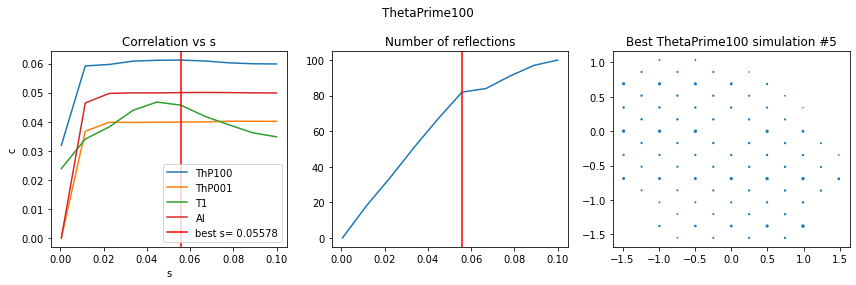

In [21]:
# 0=ThP100, 1=ThP001, 2=T1, 3=Al
show_phase_num = dp_y

# List for keeping correlation scores of matched DP from each phase for different s
corrs = np.zeros((4, num_s))

# list for keeping number of reflections in sim DP for each s
refl_nums = np.zeros((4, num_s))

best_s = np.zeros(4)
best_s_index = np.zeros(4, dtype=int)

for i in range(num_s):
    for aPhase in range(4):
        # Finding correlation score for DP for each s value
        corrs[aPhase, i] = results[aPhase, i]['correlation'][:,:,0][0][0] # [:,:,0] as 0 gives best match, [0][0] as only running one DP
        # Finding best correlation score
        if (corrs[aPhase, i] == np.amax(corrs[aPhase,:])):
            best_s[aPhase] = s[i]
            best_s_index[aPhase] = int(i)            
        # Finding number of reflections in DP by collecting number of x coords in simDP
        phase = phases[aPhase]
        simNum = results[aPhase, i]['phase_index'][0][0][0]# index 0 as want best match, first 0s as only one dp
        sim_DP = diff_libs[aPhase, i][phase]['simulations'][simNum]
        refl_nums[aPhase, i] = sim_DP.coordinates[:,0].size

    
print('Best s:', best_s[show_phase_num], 'num_s index', best_s_index[show_phase_num])

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.suptitle(phases[show_phase_num])
# Plot correlation vs s:
ax[0].plot(s, corrs[0,:], label='ThP100')   # ThP 100
ax[0].plot(s, corrs[1,:], label='ThP001')   # ThP 001
ax[0].plot(s, corrs[2,:], label='T1')       # T1
ax[0].plot(s, corrs[3,:], label='Al')       # Al
ax[0].set_xlabel('s')
ax[0].set_ylabel('c')
ax[0].set_title('Correlation vs s')
ax[0].axvline(best_s[show_phase_num],color='r', label='best s= %.5f' % best_s[show_phase_num])
ax[0].legend()
# Plot number of reflections vs s:
ax[1].plot(s, refl_nums[show_phase_num])
ax[1].set_title('Number of reflections')
ax[1].axvline(best_s[show_phase_num], color='r')

# Plot simulation for best s:
# results[phase#, s#] gives result for phase# using s#. Here find phase index for best match:
index_best_sim = results[show_phase_num, best_s_index[show_phase_num]]["template_index"][0, 0, 0]
# Finding the simulated pattern of the best match for show_phase_num (0-3)
best_sim = diff_libs[show_phase_num, best_s_index[show_phase_num]][phases[show_phase_num]]['simulations'][index_best_sim]
# And show by scatter:
ax[2].scatter(best_sim.coordinates[:,0], best_sim.coordinates[:,1], s=np.sqrt(best_sim.intensities))
ax[2].set_title('Best '+phases[show_phase_num]+' simulation #'+str(best_s_index[show_phase_num]))
fig.tight_layout()

# Plot

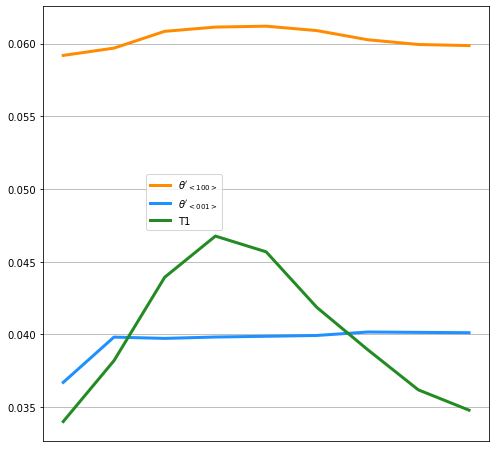

In [22]:
#plt.rcParams.update({'font.size': 44})

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(s[1:], corrs[0,1:], label='$\\theta\'_{<100>}$', c='#ff8c00', lw=3) # ThP 100
ax.plot(s[1:], corrs[1,1:], label='$\\theta\'_{<001>}$', c='#1e90ff',lw=3)  # ThP 001
ax.plot(s[1:], corrs[2,1:], label='T1', c='#228b22',lw=3) # T1
#ax.plot(s, corrs[3,:], label='Al', c= '#deaa87',lw=3) # Al
ax.set_xlabel('max{s} [Å$^{-1}$]')
ax.get_xaxis().set_visible(False)
#ax.yaxis.tick_right()
#ax.set_ylabel('c [#]')
#ax.set_title('Correlations for $\\theta\'_{<100>}$ diffraction pattern')
ax.grid(visible=True)
#ax.legend(loc = 'lower left', bbox_to_anchor=(0.45, 0.4))# ThP100
#ax.legend(loc = 'lower left', bbox_to_anchor=(0.45, 0.63))# ThP001
#ax.legend(loc = 'lower left', bbox_to_anchor=(0.45, 0.63))# T1
ax.legend(loc = 'lower left', bbox_to_anchor=(0.22, 0.475))# Al

#plt.savefig('images\corrscores_Al', transparent=False, bbox_inches='tight', pad_inches=0, dpi=300)

## Correlations

Th100 : dict_keys(['phase_index', 'template_index', 'orientation', 'correlation', 'mirrored_template'])
Th001 : dict_keys(['phase_index', 'template_index', 'orientation', 'correlation', 'mirrored_template'])
T1    : dict_keys(['phase_index', 'template_index', 'orientation', 'correlation', 'mirrored_template'])
Al    : dict_keys(['phase_index', 'template_index', 'orientation', 'correlation', 'mirrored_template'])
Th100 :
 [0.06120189 0.06096058 0.06095882 0.06088841 0.06064927]
Th001 :
 [0.03987319 0.03980797 0.03978031 0.03977971 0.03976223]
T1    :
 [0.04568212 0.04545202 0.04522528 0.04479367 0.04433464]
Al    :
 [0.05002221 0.04996819 0.04993427 0.04988244 0.04979413]


(<AxesSubplot:>, <matplotlib.collections.PathCollection at 0x19a3c5ced60>)

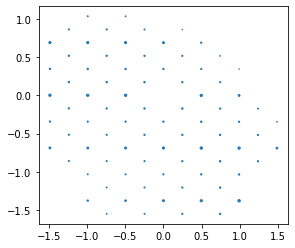

In [23]:
# Printing    [phase, s_i]
print('Th100 :', results[0, 0].keys())
print('Th001 :', results[1, 0].keys())
print('T1    :', results[2, 0].keys())
print('Al    :', results[3, 0].keys())

# Printing                [phase, s_i]                [x,y,n_best] (x,y=0 as only one DP)
print('Th100 :\n', results[0, num_s//2]['correlation'][0,0,:])
print('Th001 :\n', results[1, num_s//2]['correlation'][0,0,:])
print('T1    :\n', results[2, num_s//2]['correlation'][0,0,:])
print('Al    :\n', results[3, num_s//2]['correlation'][0,0,:])

phasenum = 0
#        [phasenum,      s                ][ phasenum name ]                [     rot#     ]
diff_libs[phasenum, best_s_index[phasenum]][phases[phasenum]]['simulations'][index_best_sim].plot() # can look manually through the matched DPs

Orientation for chosen DP is [330.         87.5008556  88.5      ] 	 Sim # 4 , Correlation: 0.061202 , s = 0.05578


Text(0.5, 1.0, 'Solution 0 sim #4')

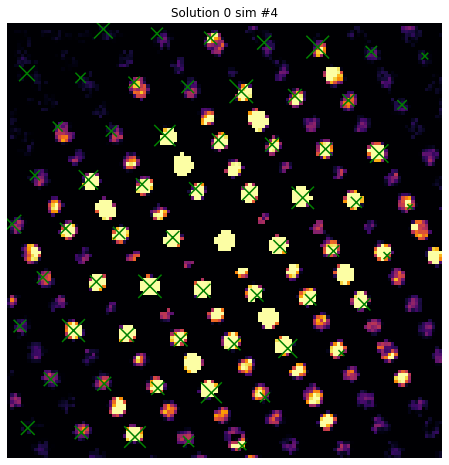

In [24]:
# Which solution to plot
n_sol = 0 # 0=best, 1=next best, ...

s_show = best_s_index[show_phase_num]
#results[phase#, s#][key]
#dp_y chosen in beggining for the phase actually in DP
solution = results[show_phase_num,s_show]["orientation"]

# Query the necessary info from the solution
sim_sol_index = results[show_phase_num,s_show]["template_index"][0, 0, n_sol]   # Collects sim # for (px, py)
mirrored_sol = results[show_phase_num,s_show]["mirrored_template"][0, 0, n_sol] # mirrored template represents whether the original template best fits (False) or the mirror image (True)
in_plane_angle = results[show_phase_num,s_show]["orientation"][0, 0, n_sol, 0]  # Orientations, the first angle is the in plane angle

# Query the appropriate template
used_sim = diff_libs[show_phase_num, best_s_index[show_phase_num]][phases[show_phase_num]]["simulations"][sim_sol_index]  # Collects the simulation fitted from template match

score = results[show_phase_num,s_show]['correlation'][0,0,n_sol]

print('Orientation for chosen DP is', results[show_phase_num,s_show]["orientation"][0, 0, n_sol], '\t Sim #', sim_sol_index, ', Correlation:',"%.6f" % score, ', s =', "%.5f" % s[s_show])

fig, ax = plt.subplots(ncols=1, figsize=(8, 8))

# calculating and plotting the IPF
solution_vectors_y = Rotation.from_euler(np.deg2rad(solution[:,:,n_sol,...]))*Vector3d.yvector()
#ax[0].imshow(get_ipf_color(solution_vectors_y))
# plotting the point we chose
#ax[0].scatter([0], [0], c="black", s=50)

# plotting the diffraction pattern and template
plot_template_over_pattern(experimental_data.data,                      # DP at px, py
                                 used_sim,                      # simulated pattern found to fit best for DP at px, py
                                 ax=ax,                         # Optional, to get DP in same fig as correlation map
                                 in_plane_angle=in_plane_angle, #
                                 coordinate_system ="cartesian", 
                                 size_factor = 100,              # This only changes size of plotted X for DP spot marking, not real change
                                 vmax=0.01,
                                 mirrored_template=mirrored_sol,
                                 find_direct_beam=False,
                                 cmap = "inferno",
                                 marker_color = "green"
                                )
#for i in ax:
ax.axis("off")
ax.set_title('Solution '+str(n_sol)+' sim #'+str(sim_sol_index))

